# Simple Linear Regression with torch.nn.Linear

- 참고 링크 : https://discuss.pytorch.org/t/strange-behaviour-of-linear-layer/41366
- 앞서 정리한 torch.nn.Parameter를 사용하는 방법보다는 이쪽이 좀 더 일반적으로 사용하는 방법이고 (아마도) 더 최적화가 잘 되어 있다
- 01 에서는 input 전체를 한번에 사용하였으므로 Stochastic Gradient Descent라기 보다는 그냥 Gradient Descent에 가까웠다
- 이번엔 Stochastic Gradient Descent가 되도록 mini batch를 나눠서 training 해 본다 
- 그런데 이걸 사용할 때 shape에 대한 문제를 잘 고려해야 한다
    - input, output에 대한 shape을 잘못 고려하면 error가 잘못 계산되서 training이 똑바로 안된다
    - 예를 들어 output이 Nx1이면 MAE가 각 row의 error를 average하겠지만, 1xN이라면 MAE가 각 column의 error를 전부다 더해서 그것을 row의 error로써 사용하게 된다

x_train.shape = torch.Size([1600, 1])
y_train.shape = torch.Size([1600, 1])
x_test.shape  = torch.Size([400, 1])
y_test.shape  = torch.Size([400, 1])


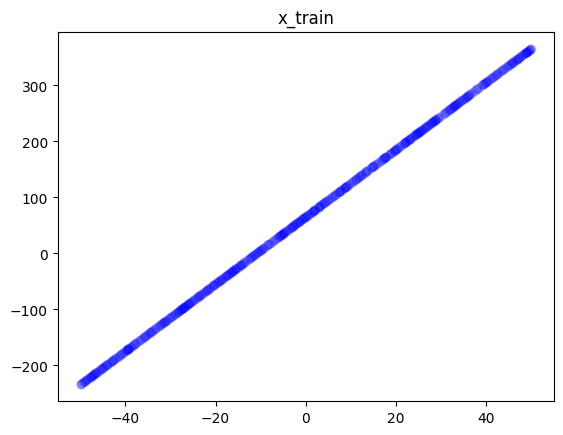

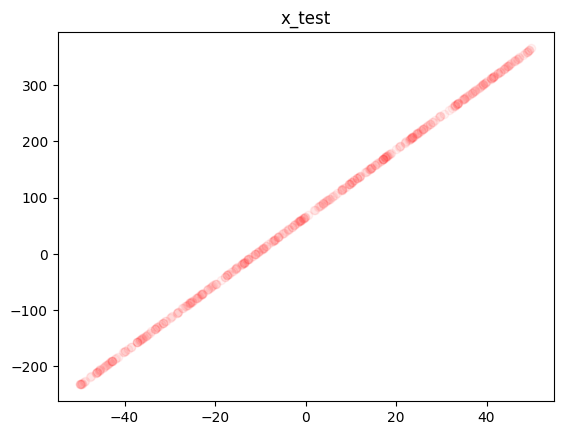

In [16]:
# 1. import 및 데이터 생성

import matplotlib.pyplot
import numpy
import torch
import sklearn.model_selection

numpy.random.seed(20231214)

n = 2000
x = (numpy.random.rand(n) - 0.5) * 100 # -50 ~ 50
weight = 6
bias = 66

y = (weight * x) + bias

# 기본적으로 numpy는 float64로 생성되므로 float32로 변환해 준다
x = x.astype(numpy.float32)
y = y.astype(numpy.float32)

# sklearn.model_selection.train_test_split을 이용하면 편리하게
# train, test 데이터를 나눌 수 있다
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2)

# numpy인 채로 사용하면 RuntimeError: Can't call numpy() on Tensor that requires grad
# 라고 나온다. 그래서 torch.from_numpy로 변환해 주어야 한다. 자동으로 변환은 안 되는 듯?
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test  = torch.from_numpy(x_test)
y_test  = torch.from_numpy(y_test)

# 위의 결과는 [N]이므로 이를 [N,1] 로 변환해 준다. 즉 각 값이 row가 되도록 한다
x_train = x_train.unsqueeze(1)
y_train = y_train.unsqueeze(1)
x_test  = x_test.unsqueeze(1)
y_test  = y_test.unsqueeze(1)

print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape  = {x_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

# data는 반드시 visualization을 한번 해 보는 것이 좋다
# (물론 이번에는 매우매우 뻔한 데이터이기는 하지만)

# 찍어 보면 2000 정도로는 생각보다 uniform 하지 않다는 걸 알 수 있음

matplotlib.pyplot.title('x_train')
matplotlib.pyplot.scatter(x_train, y_train, alpha=0.05, color='blue')
matplotlib.pyplot.show()

matplotlib.pyplot.title('x_test')
matplotlib.pyplot.scatter(x_test, y_test, alpha=0.05, color='red')
matplotlib.pyplot.show()  

In [17]:
# 2. 모델 생성

# https://discuss.pytorch.org/t/strange-behaviour-of-linear-layer/41366 

class LinearRegressionModelV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = torch.nn.Linear( # linear layer
            in_features=1, out_features=1
        )
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

def do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test):
    model = cls_model()
    loss_func = cls_loss_func() 
    optimizer = cls_optimizer(params = model.parameters(), lr=0.1)

    # GPU를 사용할 수 있다면 GPU로 옮겨 준다
    if torch.cuda.is_available():
        model = model.cuda()
        loss_func = loss_func.cuda()
        x_train = x_train.to('cuda')
        y_train = y_train.to('cuda')
        x_test = x_test.to('cuda')
        y_test = y_test.to('cuda')

    result = []

    # model을 training mode로 설정한다. 사실 default mode
    model.train()

    for e in range(epochs):
        # batch size를 32로 설정한다
        for b in range(0, len(x_train), 32):
            x_batch = x_train[b:b+32]
            y_batch = y_train[b:b+32]

            # 1. forward pass 실행
            y_pred = model(x_batch) 
            # 2. loss 계산
            loss = loss_func(y_pred, y_batch)
            # 3. gradient 초기화. 이걸 안하면 gradient가 누적된다고 한다
            optimizer.zero_grad()
            # 4. 각 요소의 gradient contribution을 계산한다 
            loss.backward() 
            # 5. gradient descent를 실제 실행한다
            optimizer.step() 
        
        if e % 10 == 0:
            model.eval() # model을 evaluation mode로 설정한다
            with torch.inference_mode():
                y_pred_test = model(x_test).clone().detach()

                train_loss = loss.clone().detach()
                test_loss = loss_func(y_pred_test, y_test).clone().detach()

                # print(f'epoch: {e}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}')
                # print(f'weights: {model.weights}, bias: {model.bias}')
                result.append((e, train_loss.to('cpu'), y_pred_test.to('cpu'), test_loss.to('cpu')))
                # print(f'{model.state_dict()}')

            model.train() # model을 training mode로 원상 복구
    
    return result
    
def draw_loss_graph(train_result):
    arr_epoch = [e for e, _, _, _ in train_result]
    arr_train_loss = [l for _, l, _, _ in train_result]
    arr_test_loss = [l for _, _, _, l in train_result]

    matplotlib.pyplot.title('loss')
    matplotlib.pyplot.plot(arr_epoch, arr_train_loss, color='blue', label='train_loss')
    matplotlib.pyplot.plot(arr_epoch, arr_test_loss, color='red', label='test_loss')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

def draw_test_result_change(epochs, train_result):
    matplotlib.pyplot.title('x_test')

    for e, _, y_pred_test, _ in train_result:
        # print(e,epochs)
        g = int(255 * (e / float(epochs)))
        b = int(255 * (1.0 - (e / float(epochs))))
        # print(g,b)
        cur_c = f'#00{g:02x}{b:02x}'
        # print(cur_c)
        x_test.to('cpu')
        
        matplotlib.pyplot.scatter(x_test, y_pred_test, alpha=0.1, color=cur_c)
        
    matplotlib.pyplot.scatter(x_test, y_test, alpha=0.1, color='red')
    matplotlib.pyplot.show()
    

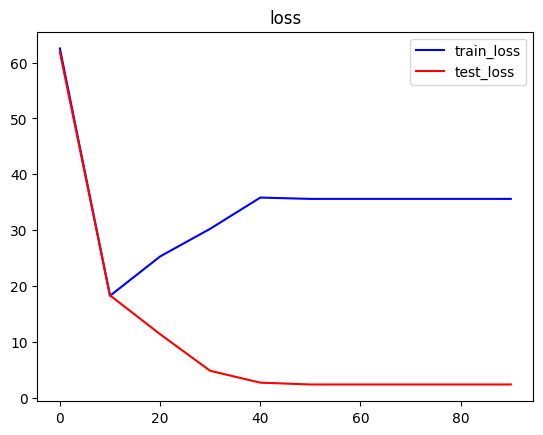

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

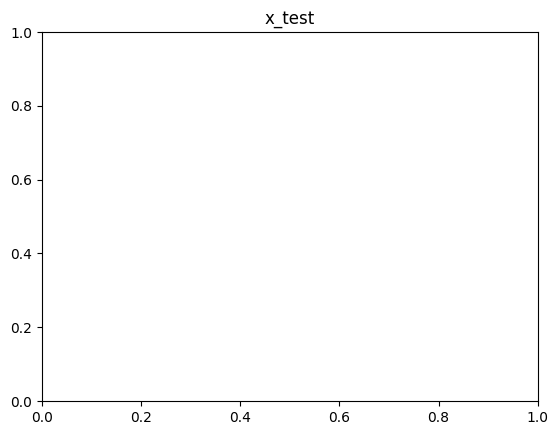

In [18]:
# 3. 학습 실행

cls_model = LinearRegressionModelV2
cls_loss_func = torch.nn.L1Loss
cls_optimizer = torch.optim.SGD

# mini batch로 하니까 훨씬 적은 epoch으로도 학습이 빠르게 잘 되는걸 확인할 수 있음
epochs = 100

train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)
draw_test_result_change(epochs, train_result)

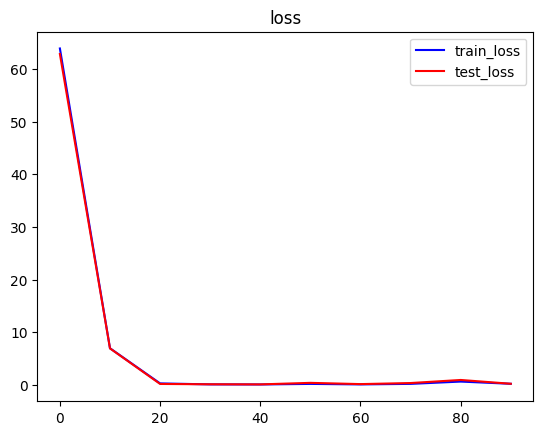

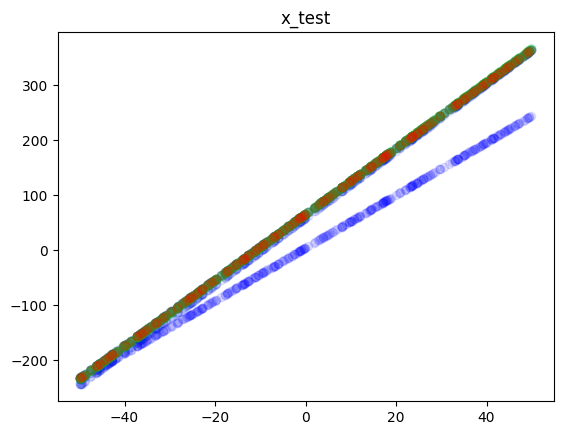

In [ ]:
# 3. Adam으로 하면 더 잘나온다

cls_model = LinearRegressionModelV2
cls_loss_func = torch.nn.L1Loss
cls_optimizer = torch.optim.Adam

# mini batch로 하니까 훨씬 적은 epoch으로도 학습이 빠르게 잘 되는걸 확인할 수 있음
epochs = 100

train_result = do_training(epochs, cls_model, cls_loss_func, cls_optimizer, x_train, y_train, x_test, y_test)
draw_loss_graph(train_result)
draw_test_result_change(epochs, train_result)